## Import necessary packages

You'll be implement your model in `KMeans.py` which should be put under the same directory as the location of `KMeans.ipynb`. Since we have enabled `autoreload`, you only need to import these packages once. You don't need to restart the kernel of this notebook nor rerun the next cell even if you change your implementation for `KMeans.py` in the meantime.

A suggestion for better productivity if you never used jupyter notebook + python script together: you can split your screen into left and right parts, and have your left part displaying this notebook and have your right part displaying your `KMeans.py`

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from KMeans import KMeans

from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.cluster import KMeans as Ref
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <font color='red'>ATTENTION: THERE ARE A TOTAL OF 6 QUESTIONS THAT NEED YOUR ANSWERS</font>

# Experiment: Synthetic Data

First, let's play with our model on some synthetic data that have clear separation for different clusters. Here, let's make a dataset of 100 elements in 5 different clusters with 10 dimensions and visualize it by manifolding it into a 2D space with t-SNE.

Note: The distance that you can observe from the t-SNE visualization may be significantly different from the real distance due to the manifold embedding. Please refer to the PCA and T-SNE lecture for more details.

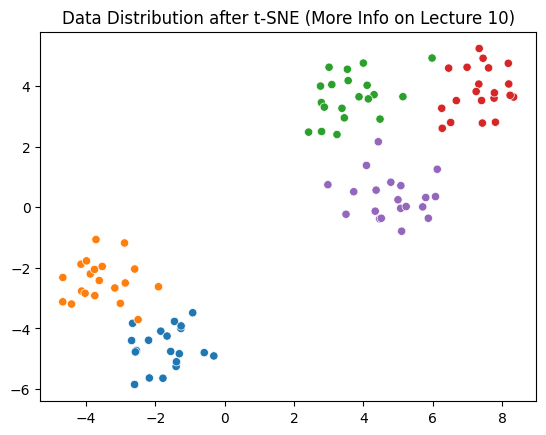

In [ ]:
X, y = make_blobs(n_samples=100, centers=5, n_features=10, random_state=42, cluster_std=2, center_box=(0, 10))

dims = TSNE(random_state=42).fit_transform(X)
dim1, dim2 = dims[:, 0], dims[:, 1]
sns.scatterplot(x=dim1, y=dim2, hue=y, palette='tab10', legend=False)
plt.title('Data Distribution after t-SNE (More Info on Lecture 10)');

Now, let's see how our algorithm performs compared to the ground truth.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Early Stopped at Iteration 3
Early Stopped at Iteration 3


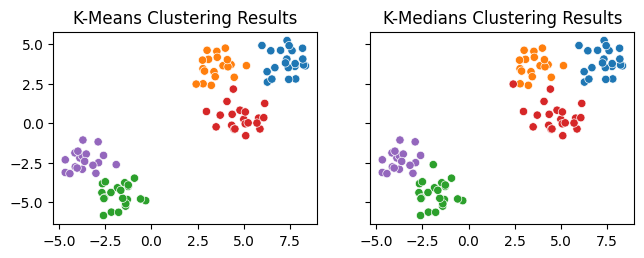

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5), sharey=True)

# This is a reference of KMeans from sklearn's implementation, which we will be using later to evaluate our model
ref_kmeans = Ref(5, init='random').fit(X).predict(X)

# This is to evaluate our KMeans model predictions
y_pred_kmeans = KMeans(5, order=2).fit(X).predict(X)
sns.scatterplot(x=dim1, y=dim2, hue=y_pred_kmeans, palette='tab10', ax=axes[0], legend=False)
axes[0].set_title('K-Means Clustering Results')

# This is to evaluate our KMedians model predictions
y_pred_kmedians = KMeans(5, order=1).fit(X).predict(X)
sns.scatterplot(x=dim1, y=dim2, hue=y_pred_kmedians, palette='tab10', ax=axes[1], legend=False)
axes[1].set_title('K-Medians Clustering Results');

<font color='red'> **Question 1: From the above two figures, which one seems better compared to the original data distribution with actual cluster indices? Can you list some possible reasons why one way performs better than the other way?** </font>

Hint: Think of how we make the synthetic data. Also, next cell block shows the detailed clustering progress over each iteration.

Answer: I think K-Means performs better than K-Medians because the synthetic data was generated using isotropic Gaussian blobs, (make_blobs = spherical assume) aligning well with the assumptions of K-Means as it also assumes spherical clusters and uses Euclidean distance, which is effective when clusters have globular shape. There aren’t too many outliers in the data, so K-Medians wouldn’t be as effective here. We can also see K-medians having some points where it shouldn't be.

Let's see how the clustering goes over each iteration

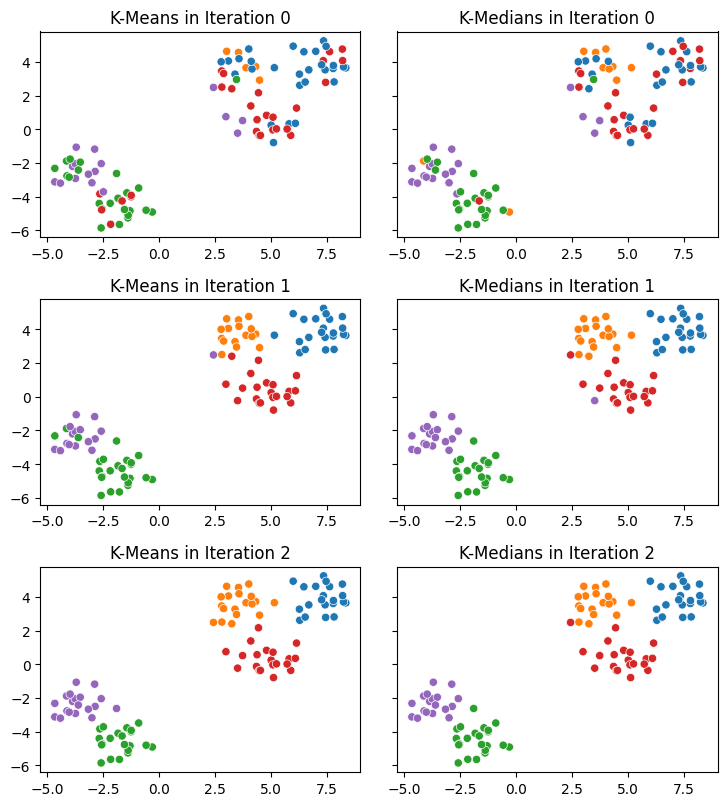

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(7.5, 8), sharey=True)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Don't worry about the fact that we train a separate model for each iteration
# since we used a fixed random seed to ensure initialization consistency
for i in range(3):
    y_pred = KMeans(5, num_iter=i, order=2).fit(X).predict(X)
    ax = axes[i][0]
    ax.title.set_text(f'K-Means in Iteration {i}')
    sns.scatterplot(x=dim1, y=dim2, hue=y_pred, palette='tab10', ax=ax, legend=False)

    y_pred = KMeans(5, num_iter=i, order=1).fit(X).predict(X)
    ax = axes[i][1]
    ax.title.set_text(f'K-Medians in Iteration {i}')
    sns.scatterplot(x=dim1, y=dim2, hue=y_pred, palette='tab10', ax=ax, legend=False);

Let's now evaluate our models with respect to sklearn's model. Here, we will be using [adjusted mutual information score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) as our metric to evaluate the performance of clustering.

Hint: If your model is correctly implemented, you should have one of the models (K-Means, K-Medians) to have the same mutual info score as sklearn's implementation.

In [ ]:
pd.DataFrame({'Reference K-Means from Sklearn vs Ground Truth': adjusted_mutual_info_score(ref_kmeans, y),
              'Our K-Means vs Ground Truth': adjusted_mutual_info_score(y_pred_kmeans, y),
              'Our K-Medians vs Ground Truth': adjusted_mutual_info_score(y_pred_kmedians, y)},
              index=['Mutual Info Score']).T

,Mutual Info Score
Reference K-Means from Sklearn vs Ground Truth,0.947515
Our K-Means vs Ground Truth,0.947515
Our K-Medians vs Ground Truth,0.904241


## Wait... What happens when we have just one outlier?

Now, let's change one observation in the dataset to be an outlier. That is, we'll set the value of the first dimension of the first point in the dataset to be `100`. Other than that, the rest of the dataset is kept completely the same as before.

As you can see in the below visualization, the manifolded figrue with t-SNE shows that there started to have points belonging to a particular cluster (according to the ground truth) appearing in the side of anothor cluster. However, if we discard the coloring of the below figure, we can still see that our dataset roughly has 5 clusters and each cluster contains an equal size of observations. We will see if this will affect the performance of our models.

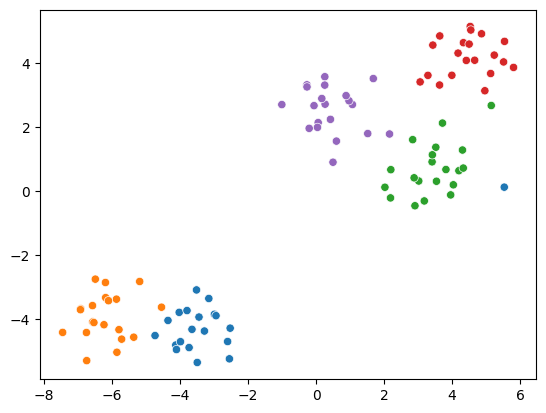

In [ ]:
# let's make an outlier here
X[0][0] = 100

dims = TSNE(random_state=42).fit_transform(X)
dim1, dim2 = dims[:, 0], dims[:, 1]
sns.scatterplot(x=dim1, y=dim2, hue=y, palette='tab10', legend=False);

Now, let's see how our algorithm performs compared to the ground truth.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Early Stopped at Iteration 4
Early Stopped at Iteration 3


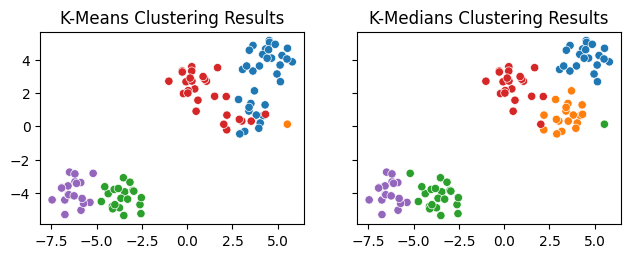

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5), sharey=True)

# This is a reference of KMeans from sklearn's implementation, which we will be using later to evaluate our model
ref_kmeans = Ref(5, init='random').fit(X).predict(X)

# This is to evaluate our KMeans model predictions
y_pred_kmeans = KMeans(5, order=2).fit(X).predict(X)
sns.scatterplot(x=dim1, y=dim2, hue=y_pred_kmeans, palette='tab10', ax=axes[0], legend=False)
axes[0].set_title('K-Means Clustering Results')

# This is to evaluate our KMedians model predictions
y_pred_kmedians = KMeans(5, order=1).fit(X).predict(X)
sns.scatterplot(x=dim1, y=dim2, hue=y_pred_kmedians, palette='tab10', ax=axes[1], legend=False)
axes[1].set_title('K-Medians Clustering Results');

<font color='red'> **Question 2: From the above two figures, which one seems better compared to the original data distribution with actual cluster indices? Can you list some possible reasons why one way performs better than the other way?** </font>

Hint: Think of how we make the synthetic data. Also, think of the consequences of using means vs using medians in finding the centers.

Answer: With the outlier now in the dataset, K-Medians will be better than K-Means, and we can clearly see that from the figures above where K-Means is messing up (right hand corner). K-Means calculates the centroid of a cluster based on the mean of lal the points in the clusters, so when we have outliers, this can cause some stunting in the position of the centroid which may provide incorrect results. For K-Medians, it is a better measure against outliers as it uses the median and Manhattan distance. We can see this once again in the graph with both colours and positioning

Let's see how the clustering goes over each iteration

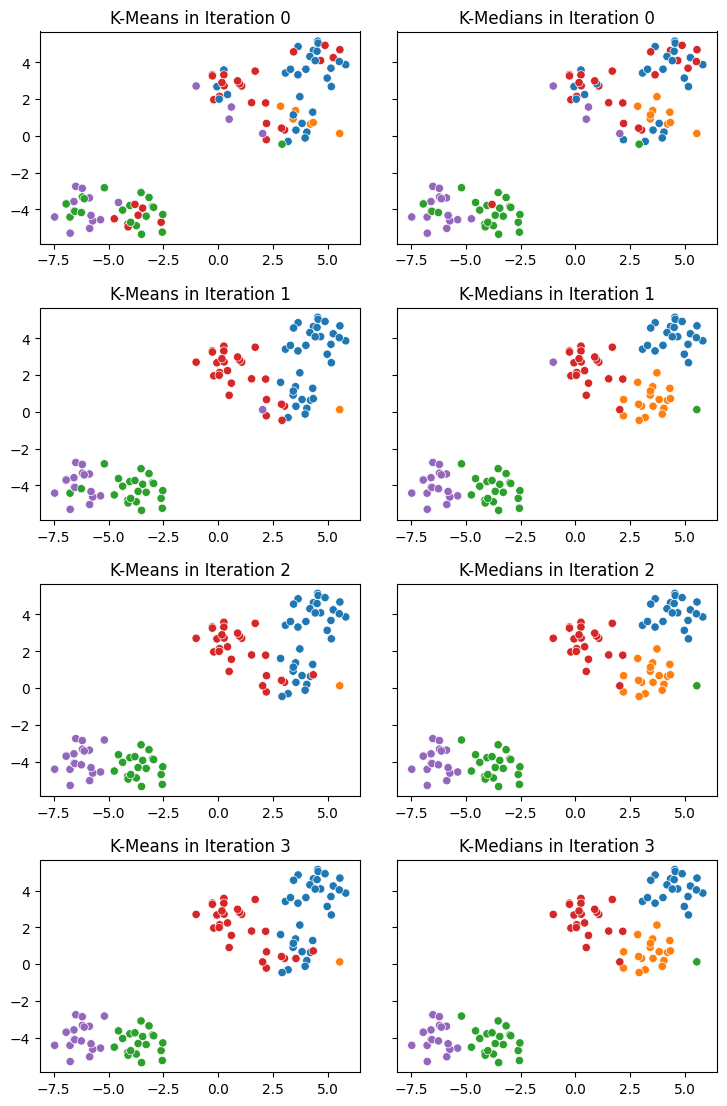

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(7.5, 11), sharey=True)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3)

for i in range(4):
    y_pred = KMeans(5, num_iter=i, order=2).fit(X).predict(X)
    ax = axes[i][0]
    ax.title.set_text(f'K-Means in Iteration {i}')
    sns.scatterplot(x=dim1, y=dim2, hue=y_pred, palette='tab10', ax=ax, legend=False)

    y_pred = KMeans(5, num_iter=i, order=1).fit(X).predict(X)
    ax = axes[i][1]
    ax.title.set_text(f'K-Medians in Iteration {i}')
    sns.scatterplot(x=dim1, y=dim2, hue=y_pred, palette='tab10', ax=ax, legend=False);

Let's now evaluate our models with respect to sklearn's model. Here, we will be using [adjusted mutual information score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) as our metric to evaluate the performance of clustering.

Hint: If your model is correctly implemented, you should one of the scores higher than the reference score, and the other score lower than the reference score.

In [ ]:
pd.DataFrame({'Reference KMeans from Sklearn vs Ground Truth': adjusted_mutual_info_score(ref_kmeans, y),
              'Our KMeans vs Ground Truth': adjusted_mutual_info_score(y_pred_kmeans, y),
              'Our KMedians vs Ground Truth': adjusted_mutual_info_score(y_pred_kmedians, y)},
              index=['Mutual Info Score']).T

,Mutual Info Score
Reference KMeans from Sklearn vs Ground Truth,0.862091
Our KMeans vs Ground Truth,0.781036
Our KMedians vs Ground Truth,0.904241


<font color='red'> **Question 3: After the above experiments, (1)Can you summarize when is better to use Euclidean distance for K-Means, and when is better to use Manhattan distance for K-Medians? (2)If a model performs better on K-Medians than the most popular K-Means, what does that mean for the dataset? (3)Are there ways you can manipulate the dataset a little bit to make the model achieve a better performance on K-Means? (4)You may noticed that Sklearn's KMeans algorithms performs better than our KMeans algorithm. What could be the cause here?** </font>

*Answer*:

(1) It's better to use Euclidean distance for K-Means when dealing with clusters that are spherical or hyper-spherical. It is sensitive to outliers however, where Manhattan distance for K-Medians is more resistant, and can handle datasets with non-linear or non-globular clusters (better for when clusters aren't spherical or diverse in density).

(2) It probably means that the dataset has outliers or clusters that aren't well represented by spherical shapes. Using medians as centroid, makes K-medians better against outliers.

(3) You could manipulate it to improve the K-Means performance by removing the outliers altogether to help it perform better. You could also reduce the dimensions to help K-Means get the structure better, or you could also scale features to lead to better performances, but this will only help so much if there are a lot of outliers we can't remove.

(4) Sklearn's implementation of K-Means is better optimized using more efficient data structures and algorithms to reduce runtime and provide more accurate results. Sklearn implementation also uses more efficient convergence criteria as it monitors things consistently.

# Experiment: Real-World Data

Now, after that we have dealt with some synthetic data, which come from a normal distribution at different centers, we will evaluate our model's performance on real-world data. Here, we will be using the [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris). Let's first visualize our data using [Multi-Dimensional Scaling](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling), which is another way to visualize multi-dimensional data into a 2D space.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


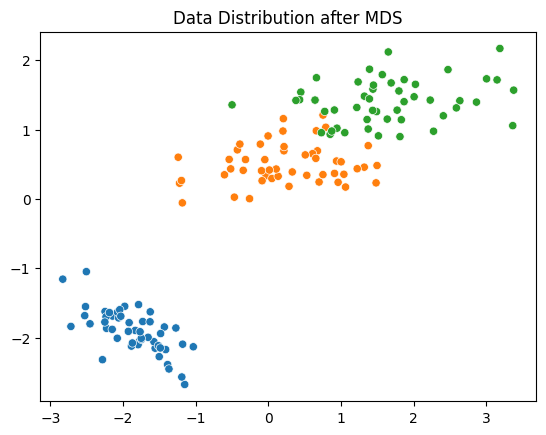

In [ ]:
data = datasets.load_iris()
X, y = data['data'], data['target']

dims = MDS(random_state=42).fit_transform(X)
dim1, dim2 = dims[:, 0], dims[:, 1]
sns.scatterplot(x=dim1, y=dim2, hue=y, palette='tab10', legend=False)
plt.title('Data Distribution after MDS');

Now, let's see how our algorithm performs compared to the ground truth.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Early Stopped at Iteration 5
Early Stopped at Iteration 4


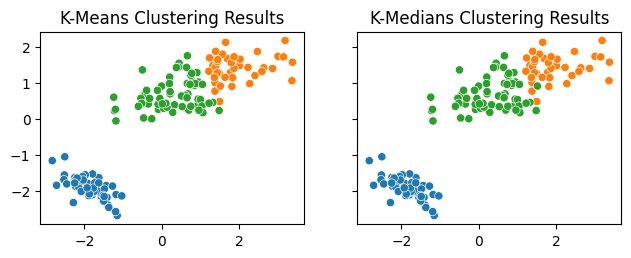

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5), sharey=True)

# This is a reference of KMeans from sklearn's implementation, which we will be using later to evaluate our model
ref_kmeans = Ref(3, init='random').fit(X).predict(X)

# This is to evaluate our KMeans model predictions
y_pred_kmeans = KMeans(3, order=2).fit(X).predict(X)
sns.scatterplot(x=dim1, y=dim2, hue=y_pred_kmeans, palette='tab10', ax=axes[0], legend=False)
axes[0].set_title('K-Means Clustering Results')

# This is to evaluate our KMedians model predictions
y_pred_kmedians = KMeans(3, order=1).fit(X).predict(X)
sns.scatterplot(x=dim1, y=dim2, hue=y_pred_kmedians, palette='tab10', ax=axes[1], legend=False)
axes[1].set_title('K-Medians Clustering Results');

<font color='red'> **Question 4: From the above results, do our models still perform that well compared to the experiment where we used the synthetic data? What makes the difference in real-life data?** </font>

Answer: It doesn't perform AS well and this is because of the complexity and noise we find in real-world data compared to synthetic given the random nature of the real world which could result in difficult things like outliers or non-linear relations. Additionally, clusters — especially ones that are nested or overlapping — are more difficult to separate in real-world compared to synthetic cases for both K-Means and K-Medians.

Let's see how the clustering goes over each iteration

Early Stopped at Iteration 4


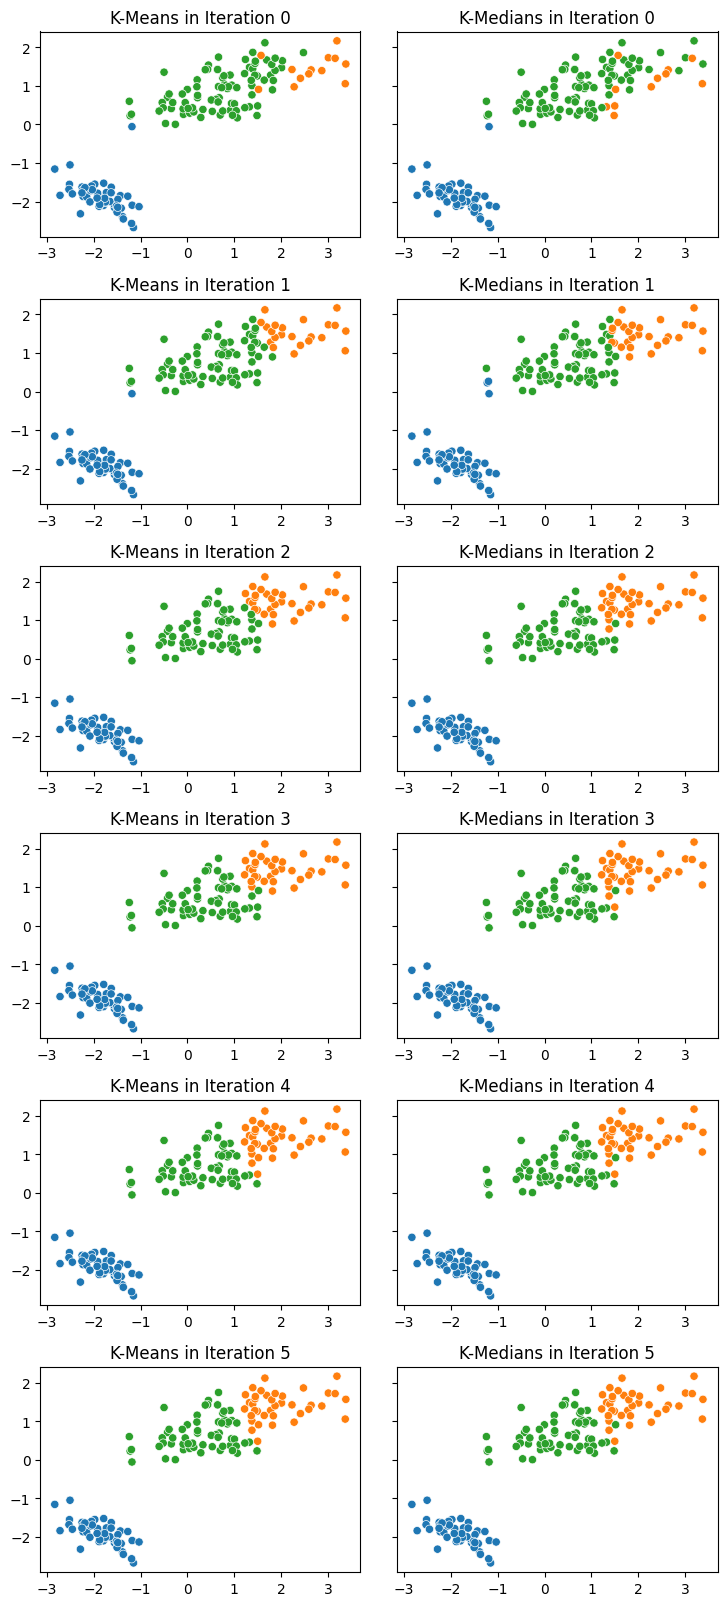

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(7.5, 16), sharey=True)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3)

for i in range(6):
    y_pred = KMeans(3, num_iter=i, order=2).fit(X).predict(X)
    ax = axes[i][0]
    ax.title.set_text(f'K-Means in Iteration {i}')
    sns.scatterplot(x=dim1, y=dim2, hue=y_pred, palette='tab10', ax=ax, legend=False)

    y_pred = KMeans(3, num_iter=i, order=1).fit(X).predict(X)
    ax = axes[i][1]
    ax.title.set_text(f'K-Medians in Iteration {i}')
    sns.scatterplot(x=dim1, y=dim2, hue=y_pred, palette='tab10', ax=ax, legend=False);

Let's now evaluate our models with respect to sklearn's model. Here, we will be using [adjusted mutual information score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) as our metric to evaluate the performance of clustering.

Hint: If your model is correctly implemented, you should have one of the models (K-Means, K-Medians) to have the same mutual info score as sklearn's implementation.

In [ ]:
pd.DataFrame({'Reference KMeans from Sklearn vs Ground Truth': adjusted_mutual_info_score(ref_kmeans, y),
              'Our KMeans vs Ground Truth': adjusted_mutual_info_score(y_pred_kmeans, y),
              'Our KMedians vs Ground Truth': adjusted_mutual_info_score(y_pred_kmedians, y)},
              index=['Mutual Info Score']).T

,Mutual Info Score
Reference KMeans from Sklearn vs Ground Truth,0.755119
Our KMeans vs Ground Truth,0.755119
Our KMedians vs Ground Truth,0.747583


## But most often time... we don't know how many clusters are there beforehand

Let us turn back to the synthetic data. For this part of the experiment, there are 1000 points in our data, and it should have 4 features and 4 centers (or 4 different types/labels).

In [ ]:
X, y = make_blobs(n_samples=1000, n_features=4, centers=4, cluster_std=2.5, random_state = 15)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

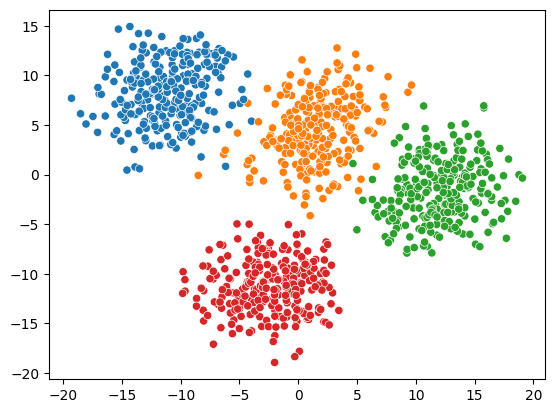

In [ ]:
dims = MDS(random_state=42).fit_transform(X)
dim1, dim2 = dims[:, 0], dims[:, 1]
sns.scatterplot(x=dim1, y=dim2, hue=y, palette='tab10', legend=False)

We will train our model using k from 2 to 10, and store the Sum of Squares Error per cluster for each k.

SSE per cluster is the squared distances between points in a cluster and the cluster center. It indicates how "compact" each cluster is.

In [ ]:
SSE = []
y_preds = []

for i in range(2, 10):
    clf = KMeans(i, order=2)
    clf.fit(X)
    y_pred = clf.predict(X)
    SSE_jlst = []
    for j in range(i):
        SSE_j = 0
        idx = np.array(y_pred == j)
        for xj in X[idx]:
            se = np.linalg.norm((xj - clf.centers[j]), ord = 2)
            SSE_j += se
        SSE_jlst.append(SSE_j)
    SSE.append(sum(SSE_jlst) / i)
    y_preds.append(y_pred)

Early Stopped at Iteration 5
Early Stopped at Iteration 9
Early Stopped at Iteration 13
Early Stopped at Iteration 18
Early Stopped at Iteration 18
Early Stopped at Iteration 17
Early Stopped at Iteration 22
Early Stopped at Iteration 22


After training our model, let's plot SSE against k. Pay attention to the trend and see if you can find a tipping point. A tipping point sometimes indicates a balance point for our model; increasing k furthur would lead to overfitting.

Text(0.5, 1.0, 'Sum of Squared Errors vs. k')

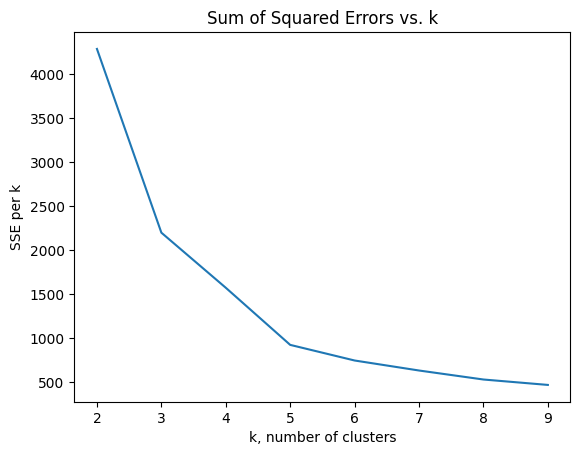

In [ ]:
x = range(2, 10)
plt.plot(x, SSE)
plt.xlabel("k, number of clusters")
plt.ylabel("SSE per k")
plt.title('Sum of Squared Errors vs. k')

<font color='red'> **Question 5: Can you find the most reasonable k based on this metric? Recall that we should have 4 clusters in this dataset. With that in mind, can you completely trust some metrics that help you determine how many clusters to use? What are the takeaways from this part of the experiment?** </font>

Answer: The most reasonable k value for this dataset seems to be 4 based on the SSE metric but relying on it completely might not be enough for determining the optimal number of clusters. Techniques like elbow method and other metrics like silhouette score could be considered to be more suitable for informed decision. The choice of the optimal clusters relies on the characteristics and goals of the dataset and analysis respectively. Clustering algorithms at the end of the day require careful examination of data in consideration of assumptions.

<font color='red'> **Question 6: In designing our model, we simplified some steps to make this implementation process easier. Can you list some potential improvements that can possibly make our model better when encountering data with noises or outliers, data with different types of distributions, or data where clusters have various distances of separation? (Hint: consider how we can work on initialization, assigning centers, data processing within the model, etc to make it better).** </font>

Answer:

- Initialization: Better initilization methods as we saw with Sklearn's K-Means++, it was better, and improved the selection of initial cluster centers
- Different algorithms: Other clustering algorithms such as spectral clustering can handle clusters with random characteristics better
- Better/more metrics: Using better or incorporating more metrics like silhouette score can help produce better results
- Hyperparameter tuning: Helps optimize things like the no. of iterations or the convergence criteria for instance could help improve performance
- Processing data: As mentioned earlier getting rid of outliers, or processing data in other ways like scaling or reducing dimensionality can help handle erroneous circumstances (noise, outliers, high-dimensions).
- Better visualization techniques: As mentioned earlier using the elbow technique and other more efficient visualization techniques can help drive meaningful analysis and insight.